In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('Downloads/LoanStats3d.csv',
    skipinitialspace=True,
    header=1)

/Users/laurakim/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (0,19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Background info from https://en.wikipedia.org/wiki/LendingClub:

LendingClub = peer-to-peer (P2P) lending company in the US. 
"The company enables borrowers to create unsecured personal loans between $1,000 and $40,000. The standard loan period is three years. 

Investors can search and browse the loan listings on LendingClub website and select loans that they want to invest in based on the information supplied about the borrower, amount of loan, loan grade, and loan purpose. 

Investors make money from interest. 

LendingClub makes money by charging borrowers an origination fee and investors a service fee."  - Wikipedia


LendingClub website: https://www.lendingclub.com/investing/institutional/overview

"Banks, financial advisors, and institutions are increasingly looking to invest in marketplace lending seeking higher yields, diversification, and low correlation.1 In partnering with LendingClub, investors can access consumer credit through whole loans, securitizations, or certificates.

With about $50 billion invested across more than 3 million customers, we’re proud to be America’s largest online credit marketplace." - LendingClub

Types of investors:
asset managers, banks, broker-dealers, hedge funds, financial advisors, insurance companies, registered investment advisors, pension funds, foundations, or endowments.

Goal of this project:
Build a classification model that will assist investors in choosing loan listings that will yield high return on their investment.  

Data exploring/cleaning: 

Dataset variable info from https://www.lendingclub.com/developers/listed-loans

In [3]:
data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,68009401,72868139.0,16000.0,16000.0,16000.0,60 months,14.85%,379.39,C,C5,...,0.0,2.0,78.9,0.0,0.0,2.0,298100.0,31329.0,281300.0,13400.0
1,68354783,73244544.0,9600.0,9600.0,9600.0,36 months,7.49%,298.58,A,A4,...,0.0,2.0,100.0,66.7,0.0,0.0,88635.0,55387.0,12500.0,75635.0
2,68466916,73356753.0,25000.0,25000.0,25000.0,36 months,7.49%,777.55,A,A4,...,0.0,0.0,100.0,20.0,0.0,0.0,373572.0,68056.0,38400.0,82117.0
3,68466961,73356799.0,28000.0,28000.0,28000.0,36 months,6.49%,858.05,A,A2,...,0.0,0.0,91.7,22.2,0.0,0.0,304003.0,74920.0,41500.0,42503.0
4,68495092,73384866.0,8650.0,8650.0,8650.0,36 months,19.89%,320.99,E,E3,...,0.0,12.0,100.0,50.0,1.0,0.0,38998.0,18926.0,2750.0,18248.0


In [4]:
data.shape

(421097, 111)

In [5]:
data=data.drop(['id','member_id', 'funded_amnt'], axis=1)
#loan_amnt same as funded_amnt

In [6]:
data[['loan_amnt','funded_amnt_inv']].describe()

,loan_amnt,funded_amnt_inv
count,421095.000000,421095.000000
mean,15240.285862,15234.156412
std,8571.325901,8567.935752
min,1000.000000,900.000000
25%,8500.000000,8500.000000
50%,14000.000000,14000.000000
75%,20000.000000,20000.000000
max,35000.000000,35000.000000


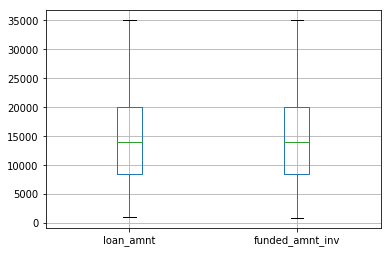

In [7]:
boxplot = data.boxplot(column=['loan_amnt','funded_amnt_inv'])
#Expected graph as loans range from 1000 - 40,000 as stated above

In [8]:
print(data['loan_amnt'].isnull().mean()*100)
print(data['funded_amnt_inv'].isnull().mean()*100)
#very small.  Will drop them.

0.00047494995214879233
0.00047494995214879233


In [9]:
data=data.dropna(subset=['loan_amnt', 'funded_amnt_inv'])

In [10]:
data['term']=data['term'].str.extract('(\d+)')

In [11]:
data.rename(columns = {'term':'term in months'}, inplace = True)

In [12]:
import seaborn as sns
sns.set()

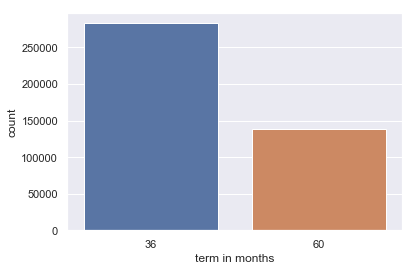

In [13]:
sns.countplot('term in months', data=data)
#loan should either be repaid or renegotiated after this loan period

In [14]:
data.groupby('term in months')['funded_amnt_inv'].mean()

term in months
36    12802.024646
60    20227.660338
Name: funded_amnt_inv, dtype: float64

More borrowers with a shorter loan period (36 months).  
Their average loan funded amount by investors is about half of the amount the borrowers with loan period of 60 months 

In [15]:
print(data['term in months'].isnull().mean()*100)

0.0


In [16]:
data['int_rate']=pd.to_numeric(data['int_rate'].str.strip('%'), errors='coerce')
data.rename(columns = {'int_rate':'interest rate in %'}, inplace = True)

In [17]:
data['interest rate in %'].describe()

count    421095.000000
mean         12.600388
std           4.318453
min           5.320000
25%           9.170000
50%          12.290000
75%          15.590000
max          28.990000
Name: interest rate in %, dtype: float64

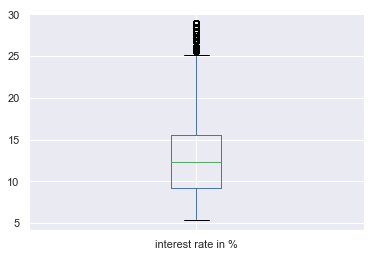

In [18]:
boxplot = data.boxplot(column=['interest rate in %'])
#interest rate: based on the lender, borrower's credit score and history.
#these interest rate ranging from 5% - 30% is typical for people with fair to good credit

In [19]:
data1_corr=data.corr()
(data1_corr['interest rate in %']).sort_values(ascending=False)
#low correlation with other variables other than total_rec_int (interest received to date)

interest rate in %         1.000000
total_rec_int              0.504617
all_util                   0.287799
dti_joint                  0.287345
inq_last_12m               0.257077
num_tl_op_past_12m         0.256831
open_il_12m                0.245028
percent_bc_gt_75           0.233942
inq_last_6mths             0.231139
acc_open_past_24mths       0.228782
bc_util                    0.226620
open_acc_6m                0.225983
open_il_24m                0.199403
il_util                    0.183550
open_rv_12m                0.176723
open_rv_24m                0.171230
inq_fi                     0.170973
loan_amnt                  0.140572
funded_amnt_inv            0.140209
installment                0.124426
collection_recovery_fee    0.123180
recoveries                 0.119825
out_prncp                  0.106315
out_prncp_inv              0.106081
total_pymnt                0.087256
total_pymnt_inv            0.087028
dti                        0.077932
last_pymnt_amnt            0

In [20]:
print(data['interest rate in %'].isnull().mean()*100)

0.0


In [21]:
#will keep interest rate in % column as the way it is

In [22]:
data['installment'].describe()

count    421095.000000
mean        441.860087
std         244.851179
min          23.400000
25%         263.930000
50%         385.410000
75%         578.790000
max        1445.460000
Name: installment, dtype: float64

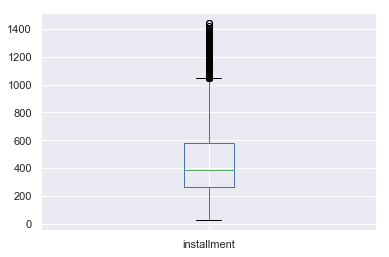

In [23]:
data.boxplot(column=['installment'])

In [24]:
print(data['installment'].isnull().mean()*100)

0.0


In [25]:
(data1_corr['installment']).sort_values(ascending=False)
#I would keep this column the way it is as well as I do not see anything unusual with this data: 
#higher the loan amount, total payment, principal, etc. = higher installment borrower makes

installment                       1.000000
loan_amnt                         0.941205
funded_amnt_inv                   0.941187
total_pymnt                       0.732579
total_pymnt_inv                   0.732545
total_rec_int                     0.654990
total_rec_prncp                   0.608280
out_prncp_inv                     0.506745
out_prncp                         0.506732
annual_inc_joint                  0.405141
max_bal_bc                        0.385606
total_bc_limit                    0.358718
tot_hi_cred_lim                   0.315373
revol_bal                         0.314090
total_rev_hi_lim                  0.303476
annual_inc                        0.297393
tot_cur_bal                       0.295468
total_bal_ex_mort                 0.265224
last_pymnt_amnt                   0.264130
avg_cur_bal                       0.215902
num_bc_sats                       0.208238
num_actv_bc_tl                    0.202271
mort_acc                          0.202128
num_bc_tl  

[Text(0, 0, 'C1'),
 Text(0, 0, 'C2'),
 Text(0, 0, 'B4'),
 Text(0, 0, 'C3'),
 Text(0, 0, 'C4'),
 Text(0, 0, 'B3'),
 Text(0, 0, 'B5'),
 Text(0, 0, 'A5'),
 Text(0, 0, 'B2'),
 Text(0, 0, 'B1'),
 Text(0, 0, 'C5'),
 Text(0, 0, 'D1'),
 Text(0, 0, 'A4'),
 Text(0, 0, 'D2'),
 Text(0, 0, 'A1'),
 Text(0, 0, 'D3'),
 Text(0, 0, 'A2'),
 Text(0, 0, 'D4'),
 Text(0, 0, 'A3'),
 Text(0, 0, 'D5'),
 Text(0, 0, 'E1'),
 Text(0, 0, 'E2'),
 Text(0, 0, 'E3'),
 Text(0, 0, 'E4'),
 Text(0, 0, 'E5'),
 Text(0, 0, 'F1'),
 Text(0, 0, 'F2'),
 Text(0, 0, 'F3'),
 Text(0, 0, 'F4'),
 Text(0, 0, 'F5'),
 Text(0, 0, 'G1'),
 Text(0, 0, 'G2'),
 Text(0, 0, 'G3'),
 Text(0, 0, 'G4'),
 Text(0, 0, 'G5')]

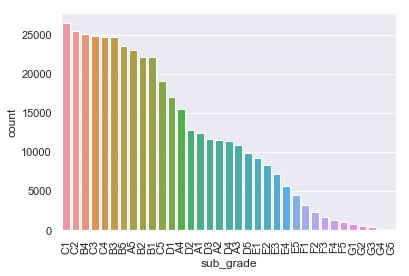

In [26]:
ax= sns.countplot('sub_grade', data=data, order = data['sub_grade'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

[Text(0, 0, 'C'),
 Text(0, 0, 'B'),
 Text(0, 0, 'A'),
 Text(0, 0, 'D'),
 Text(0, 0, 'E'),
 Text(0, 0, 'F'),
 Text(0, 0, 'G')]

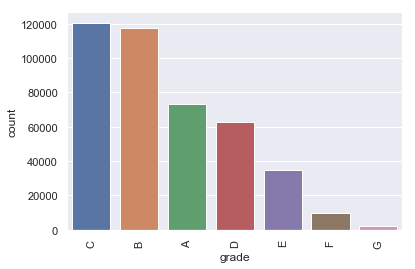

In [27]:
ax= sns.countplot('grade', data=data, order = data['grade'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

I will drop 'grade' column and use 'sub_grade' column.  

Columns 'grade' and 'sub_grade:
How LendingClub assigns Loan grade:
https://www.lendingclub.com/foliofn/rateDetail.action

Sub-grade:  interest rate, borrower's risk and volatility, credit score, and etc. adjusted to loan amount and loan terms.  

In [28]:
data=data.drop(['grade'], axis=1)

In [29]:
data=pd.get_dummies(data=data, columns=['sub_grade'])

emp_title=employment title
emp_length=employement length in months.  Null= not employed.

If they are correlated with loan status (b/w categorical variables), keep.

In [30]:
a=pd.crosstab(index=data['emp_title'], columns=data['loan_status'])

In [31]:
c=pd.crosstab(index=data['emp_length'], columns=data['loan_status'])
c

loan_status,Charged Off,Current,Default,Fully Paid,In Grace Period,Late (16-30 days),Late (31-120 days)
emp_length,,,,,,,
1 year,2152,18505,46,5666,297,140,667
10+ years,8632,97640,244,30067,1447,581,2910
2 years,2684,25319,83,7982,401,136,892
3 years,2370,22670,68,7045,351,158,768
4 years,1734,16619,57,5160,271,101,564
5 years,1790,16938,52,5216,253,110,571
6 years,1166,11500,28,3550,183,61,350
7 years,1281,12413,33,3977,203,88,419
8 years,1492,14573,43,4621,219,101,511


[Text(0, 0, '10+ years'),
 Text(0, 0, '8 years'),
 Text(0, 0, '5 years'),
 Text(0, 0, '3 years'),
 Text(0, 0, '6 years'),
 Text(0, 0, '1 year'),
 Text(0, 0, '4 years'),
 Text(0, 0, '7 years'),
 Text(0, 0, '2 years'),
 Text(0, 0, '9 years'),
 Text(0, 0, '< 1 year')]

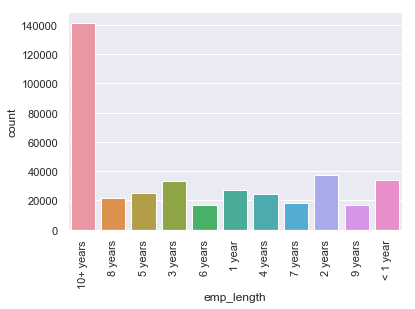

In [32]:
ax=sns.countplot('emp_length', data=data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

Too many columns to select features this way... will use PCA.  Let's clean up the data first

In [33]:
data['emp_length']=data['emp_length'].str.replace(' years', '')

In [34]:
data['emp_length']=data['emp_length'].str.replace('+', '')

In [35]:
data['zip_code']=data['zip_code'].str.replace('xx', '')

In [36]:
data['revol_util']=data['revol_util'].str.replace('%', '')

In [37]:
data.dtypes

loan_amnt                 float64
funded_amnt_inv           float64
term in months             object
interest rate in %        float64
installment               float64
emp_title                  object
emp_length                 object
home_ownership             object
annual_inc                float64
verification_status        object
issue_d                    object
loan_status                object
pymnt_plan                 object
url                        object
desc                       object
purpose                    object
title                      object
zip_code                   object
addr_state                 object
dti                       float64
delinq_2yrs               float64
earliest_cr_line           object
inq_last_6mths            float64
mths_since_last_delinq    float64
mths_since_last_record    float64
open_acc                  float64
pub_rec                   float64
revol_bal                 float64
revol_util                 object
total_acc     

In [38]:
#replace column with small number of missing data with its' median value
for col in data.dtypes[data.dtypes == 'float64'].index:
    data[col].fillna(data[col].median(), inplace=True)

In [39]:
data.isnull().mean()*100

loan_amnt                  0.000000
funded_amnt_inv            0.000000
term in months             0.000000
interest rate in %         0.000000
installment                0.000000
emp_title                  5.669505
emp_length                 5.655968
home_ownership             0.000000
annual_inc                 0.000000
verification_status        0.000000
issue_d                    0.000000
loan_status                0.000000
pymnt_plan                 0.000000
url                        0.000000
desc                      99.989314
purpose                    0.000000
title                      0.031347
zip_code                   0.000000
addr_state                 0.000000
dti                        0.000000
delinq_2yrs                0.000000
earliest_cr_line           0.000000
inq_last_6mths             0.000000
mths_since_last_delinq     0.000000
mths_since_last_record     0.000000
open_acc                   0.000000
pub_rec                    0.000000
revol_bal                  0

In [40]:
#drop columns with large amount of missing data:
data=data.drop(['mths_since_recent_revol_delinq','mths_since_recent_inq','mths_since_recent_bc_dlq','mths_since_last_record','mths_since_last_delinq','desc'], axis=1)

In [41]:
data.isnull().mean()*100

loan_amnt              0.000000
funded_amnt_inv        0.000000
term in months         0.000000
interest rate in %     0.000000
installment            0.000000
emp_title              5.669505
emp_length             5.655968
home_ownership         0.000000
annual_inc             0.000000
verification_status    0.000000
issue_d                0.000000
loan_status            0.000000
pymnt_plan             0.000000
url                    0.000000
purpose                0.000000
title                  0.031347
zip_code               0.000000
addr_state             0.000000
dti                    0.000000
delinq_2yrs            0.000000
earliest_cr_line       0.000000
inq_last_6mths         0.000000
open_acc               0.000000
pub_rec                0.000000
revol_bal              0.000000
revol_util             0.038471
total_acc              0.000000
initial_list_status    0.000000
out_prncp              0.000000
out_prncp_inv          0.000000
                         ...   
sub_grad

In [42]:
data=data.dropna(subset=['emp_title','emp_length','title','revol_util','issue_d'])

In [43]:
data.shape

(396735, 135)

In [44]:
data=pd.get_dummies(data=data, columns=['initial_list_status','title','home_ownership','verification_status','application_type','purpose','addr_state'])

In [45]:
data.head()

,loan_amnt,funded_amnt_inv,term in months,interest rate in %,installment,emp_title,emp_length,annual_inc,issue_d,loan_status,...,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY
0,16000.0,16000.0,60,14.85,379.39,Bookkeeper/Accounting,10,48000.0,Dec-2015,Current,...,0,0,0,0,0,0,0,0,0,0
1,9600.0,9600.0,36,7.49,298.58,tech,8,60000.0,Dec-2015,Current,...,0,0,0,0,0,0,0,0,0,0
2,25000.0,25000.0,36,7.49,777.55,Sales Manager,10,109000.0,Dec-2015,Fully Paid,...,0,0,0,0,1,0,0,0,0,0
3,28000.0,28000.0,36,6.49,858.05,Senior Manager,10,92000.0,Dec-2015,Current,...,0,0,0,0,0,0,0,0,0,0
4,8650.0,8650.0,36,19.89,320.99,Program Coordinator,8,55000.0,Dec-2015,Fully Paid,...,0,0,0,0,0,0,0,0,0,0


Will drop columns that do not seem to affect loan status:

In [46]:
data=data.drop(['url','earliest_cr_line','last_pymnt_d','next_pymnt_d','last_credit_pull_d','verification_status_joint','issue_d'], axis=1)

In [47]:
data.loc[data['emp_length']== '< 1 year']

,loan_amnt,funded_amnt_inv,term in months,interest rate in %,installment,emp_title,emp_length,annual_inc,loan_status,pymnt_plan,...,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY
27,17600.0,17600.0,36,5.32,530.03,Network Security Specialist III,< 1 year,88000.0,Fully Paid,n,...,0,0,0,0,0,0,0,0,0,0
30,16000.0,16000.0,60,17.97,406.04,Professional Sales Associate,< 1 year,109000.0,Fully Paid,n,...,0,0,0,0,0,0,0,0,0,0
34,21000.0,21000.0,60,13.99,488.53,Resident physician,< 1 year,52000.0,Current,n,...,0,0,0,0,0,0,0,0,0,0
41,8650.0,8650.0,36,5.32,260.50,Associate Consultant,< 1 year,100000.0,Current,n,...,0,0,0,0,0,0,0,0,0,0
61,21875.0,21875.0,36,11.99,726.46,Wire Technician,< 1 year,47590.0,Current,n,...,0,0,0,0,0,0,0,0,0,0
84,8000.0,8000.0,36,10.78,261.08,Counselor,< 1 year,45000.0,Current,n,...,0,0,0,0,0,0,0,0,0,0
93,10000.0,10000.0,60,16.59,246.33,Emergency Department technician,< 1 year,30000.0,Fully Paid,n,...,0,0,0,0,0,0,0,0,0,0
100,3600.0,3600.0,36,11.48,118.68,Systems Administrator,< 1 year,85000.0,Current,n,...,0,0,0,0,1,0,0,0,0,0
124,10000.0,10000.0,36,12.88,336.37,Truck Driver,< 1 year,60000.0,Fully Paid,n,...,0,0,0,0,0,0,1,0,0,0
143,20000.0,20000.0,36,10.78,652.70,Driver,< 1 year,55000.0,Current,n,...,0,0,0,0,0,0,0,0,0,0


In [48]:
data.loc[data['emp_length']== '1 year']

,loan_amnt,funded_amnt_inv,term in months,interest rate in %,installment,emp_title,emp_length,annual_inc,loan_status,pymnt_plan,...,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY
12,16000.0,16000.0,60,12.88,363.07,Senior Structural Designer,1 year,70000.0,Current,n,...,0,0,1,0,0,0,0,0,0,0
31,12000.0,12000.0,36,10.78,391.62,Public Affairs Specialist,1 year,98000.0,Current,n,...,0,0,0,0,0,0,1,0,0,0
64,16000.0,16000.0,60,13.44,367.67,Merchandise Manager,1 year,42000.0,Current,n,...,0,0,0,0,0,0,0,0,0,0
70,25000.0,25000.0,36,5.32,752.87,Director,1 year,150000.0,Current,n,...,0,0,0,0,0,1,0,0,0,0
87,15000.0,15000.0,36,10.78,489.52,Coaching General Manager,1 year,40000.0,Current,n,...,0,0,1,0,0,0,0,0,0,0
91,9000.0,9000.0,36,9.17,286.92,Truck Driver,1 year,50000.0,Current,n,...,0,0,0,0,0,0,0,0,0,0
123,8000.0,8000.0,36,5.32,240.92,Sales Person,1 year,50000.0,Fully Paid,n,...,0,0,0,0,0,0,0,0,0,0
149,16000.0,16000.0,36,15.77,560.70,President,1 year,70000.0,Current,n,...,0,0,0,0,0,0,0,0,0,0
160,12600.0,12600.0,60,14.85,298.77,VP of Operations,1 year,175000.0,Fully Paid,n,...,0,0,0,0,0,0,0,0,0,0
165,35000.0,35000.0,36,9.17,1115.77,Director,1 year,105000.0,Fully Paid,n,...,0,0,0,0,0,0,0,0,0,0


In [49]:
data['emp_length']=data['emp_length'].replace({'1 year': 1, '< 1 year': 0})

loan status total:
charged off:29178 (collection agencies step in)
current: 287414 (one or more payments have been completed and no payments are past due)
default: 796
full paid: 87989 (loan has been repaid in full, including all principal + interest) 
In grace period: 4320 (loan payment due period.  If paid during this period, marked as"Paid on time" and no late interest is charged). 
late(16-30 days): 1888 (over due for more than 3 days but < 31 days)
late (31-120 days): 9510 (over due for > 31 but < 120 days) 

“Most lenders report as soon as you’re 30 days late...” (https://www.bankrate.com/finance/debt/debt-delinquency-timeline-what-to-expect-1.aspx)


As an investor, would like to avoid the risk of funding borrowers that will end up with loan status of 'late (31-120 days), 'default' and 'charged off'.  

Based on borrower's given info, would like to predict if he/she is more similar to 'full paid' loan status group vs. 'charged off/default/late (31-120 days)' loan status group:  less risky group vs higher risky group to invest in.

In [50]:
data['loan_status']=data['loan_status'].replace({'Fully Paid': 'low risk', 'Charged Off': 'high risk', 'Late (31-120 days)': 'high risk', 'Default':'high risk'})

will drop loan_status column with values current, in grace period, and late (16-30 days) as they can't be labeled as either high or low risk for the purpose of this project

In [51]:
data.shape

(396735, 222)

In [52]:
data.drop(data.loc[data['loan_status']=='Current'].index, inplace=True)

In [53]:
data.drop(data.loc[data['loan_status']=='In Grace Period'].index, inplace=True)

In [54]:
data.drop(data.loc[data['loan_status']=='Late (16-30 days)'].index, inplace=True)

In [55]:
data.shape

(120538, 222)

In [56]:
len(data.loc[data['loan_status']=='high risk'])

36662

In [57]:
len(data.loc[data['loan_status']=='low risk'])

83876

In [58]:
data1=pd.DataFrame(data.loc[data['loan_status']=='high risk'])
data2=pd.DataFrame(data.loc[data['loan_status']=='low risk'])

we have more low risk samples than high risk (about twice as much).
do random sample selection for low risk (half the original size) to prevent class imbalance.

Then will perform PCA for feature selection

In [59]:
data3=pd.DataFrame(data2.sample(frac=0.45, random_state=10))

In [60]:
frames = [data1, data3]

final_data_table = pd.concat(frames)

In [61]:
final_data_table=final_data_table.drop(['emp_title','pymnt_plan'], axis=1)

In [62]:
final_data_table.head()

,loan_amnt,funded_amnt_inv,term in months,interest rate in %,installment,emp_length,annual_inc,loan_status,zip_code,dti,...,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY
76,23975.0,23975.0,60,19.89,633.73,10,70000.0,high risk,220,33.20,...,0,0,0,0,1,0,0,0,0,0
83,27300.0,27300.0,36,17.27,977.00,10,65000.0,high risk,117,25.63,...,0,0,0,0,0,0,0,0,0,0
94,23100.0,23100.0,60,20.50,618.46,2,110000.0,high risk,197,20.43,...,0,0,0,0,0,0,0,0,0,0
126,14400.0,14400.0,60,19.48,377.36,3,73320.0,high risk,136,17.02,...,0,0,0,0,0,0,0,0,0,0
140,25825.0,25825.0,60,26.06,774.14,6,68000.0,high risk,207,31.68,...,0,0,0,0,0,0,0,0,0,0


In [63]:
df_dummies = pd.get_dummies(final_data_table['loan_status'])
del df_dummies[df_dummies.columns[-1]]
df_new = pd.concat([final_data_table, df_dummies], axis=1)
del df_new['loan_status']
#high risk: 1
#low risk: 0

In [64]:
df_new['term in months']=pd.to_numeric(df_new['term in months'])

In [65]:
df_new=df_new.apply(pd.to_numeric)

In [66]:
x = pd.DataFrame(df_new.values)
x.shape

(74406, 220)

In [253]:
correlation_matrix = pd.DataFrame(np.corrcoef(x.T))
correlation_matrix.iloc[:,-1]
#correlation of loan_status to explanatory variables

0      0.066106
1      0.065975
2      0.176587
3      0.319071
4      0.055459
5     -0.042087
6     -0.056781
7     -0.036067
8      0.178589
9      0.028447
10     0.078784
11     0.033004
12     0.016805
13    -0.019224
14     0.120984
15    -0.038350
16     0.328939
17     0.328954
18    -0.592647
19    -0.592667
20    -0.681928
21     0.161219
22     0.147583
23     0.306699
24     0.308172
25    -0.673797
26     0.025617
27    -0.004981
28          NaN
29     0.000002
         ...   
190   -0.003593
191    0.007075
192    0.002354
193    0.009337
194   -0.008163
195    0.004364
196   -0.001407
197    0.004150
198   -0.018565
199    0.010473
200    0.002176
201    0.009183
202    0.034593
203    0.011026
204    0.013215
205   -0.023982
206    0.002765
207   -0.000362
208   -0.010436
209    0.010169
210    0.003675
211    0.002166
212   -0.017992
213    0.001604
214   -0.012299
215   -0.024443
216   -0.008130
217   -0.002719
218   -0.003301
219    1.000000
Name: 219, Length: 220, 

In [337]:
final_data_table.columns[3]

'interest rate in %'

explanatory variables with highest correlation with loan_status:

column[18]: 'out_prncp_inv'   
column[19]: 'total_pymnt'     
column[20]: 'total_pymnt_inv' 
column[25]: 'collection_recovery_fee'

HOWEVER, THIS DATA IS COLLECTED AFTER THE LOAN ALREADY GOT APPROVED AND INVESTORS ALREADY MADE THEIR INVESTMENTS.

column[0] (loan amount) and column[4] (installment) seem to be correlated with above four columns.


column[3] (interest rate in %)
column[16] (total_acc)
column[17] (out_prncp)
column[23] (total_rec_late_fee)
column[24] (recoveries)

These 5 features have moderate correlation with loan status (with corr about 0.3)

But only columns 3 and 16 are the ones that are available prior to making an investment.

In [158]:
correlation_matrix.iloc[:,18]

0      0.639391
1      0.639540
2      0.126663
3     -0.061894
4      0.624607
5      0.077072
6      0.225599
7      0.027578
8     -0.100701
9     -0.024362
10    -0.062553
11     0.099332
12    -0.064304
13     0.238646
14     0.025725
15     0.153598
16    -0.088147
17    -0.088136
18     1.000000
19     0.999997
20     0.979337
21     0.433895
22    -0.036131
23    -0.121317
24    -0.123344
25     0.856866
26    -0.034842
27     0.000194
28          NaN
29     0.010923
         ...   
190   -0.003381
191   -0.008454
192   -0.004642
193   -0.010309
194    0.001510
195   -0.009110
196    0.000998
197   -0.005885
198    0.005709
199    0.007515
200   -0.003219
201   -0.018559
202   -0.032634
203   -0.019317
204   -0.008731
205    0.003792
206   -0.004489
207   -0.001629
208    0.006690
209   -0.009467
210   -0.003465
211    0.023384
212    0.005777
213    0.007466
214    0.002491
215    0.020743
216   -0.007789
217    0.003660
218    0.001392
219   -0.592647
Name: 18, Length: 220, d

In [159]:
correlation_matrix.iloc[:,19]

0      0.639358
1      0.639513
2      0.126584
3     -0.062087
4      0.624574
5      0.077088
6      0.225627
7      0.027563
8     -0.100779
9     -0.024370
10    -0.062593
11     0.099339
12    -0.064298
13     0.238643
14     0.025646
15     0.153617
16    -0.088192
17    -0.088180
18     0.999997
19     1.000000
20     0.979342
21     0.433846
22    -0.036147
23    -0.121306
24    -0.123336
25     0.856843
26    -0.034860
27     0.000191
28          NaN
29     0.010924
         ...   
190   -0.003375
191   -0.008442
192   -0.004659
193   -0.010314
194    0.001510
195   -0.009117
196    0.000992
197   -0.005898
198    0.005727
199    0.007515
200   -0.003214
201   -0.018559
202   -0.032624
203   -0.019311
204   -0.008739
205    0.003787
206   -0.004481
207   -0.001617
208    0.006671
209   -0.009463
210   -0.003458
211    0.023364
212    0.005761
213    0.007483
214    0.002502
215    0.020739
216   -0.007778
217    0.003665
218    0.001399
219   -0.592667
Name: 19, Length: 220, d

In [160]:
correlation_matrix.iloc[:,20]

0      0.525021
1      0.525180
2      0.036922
3     -0.166324
4      0.519611
5      0.070827
6      0.208385
7      0.028439
8     -0.125099
9     -0.029569
10    -0.076734
11     0.081105
12    -0.062108
13     0.215345
14    -0.007274
15     0.137966
16    -0.152870
17    -0.152858
18     0.979337
19     0.979342
20     1.000000
21     0.271146
22    -0.070419
23    -0.237913
24    -0.237873
25     0.892751
26    -0.035445
27     0.001382
28          NaN
29     0.008910
         ...   
190   -0.003197
191   -0.009168
192   -0.004460
193   -0.010130
194    0.003450
195   -0.010274
196    0.001912
197   -0.004005
198    0.008252
199    0.005530
200   -0.003330
201   -0.018507
202   -0.028216
203   -0.019273
204   -0.009948
205    0.007216
206   -0.005676
207   -0.000624
208    0.005508
209   -0.009981
210   -0.004849
211    0.019318
212    0.006482
213    0.004059
214    0.004370
215    0.020777
216   -0.005284
217    0.003697
218    0.000530
219   -0.681928
Name: 20, Length: 220, d

In [161]:
correlation_matrix.iloc[:,25]

0      0.406115
1      0.406214
2      0.102073
3     -0.099546
4      0.373701
5      0.067860
6      0.165972
7      0.030355
8     -0.104748
9     -0.030420
10    -0.056550
11     0.060347
12    -0.049823
13     0.173997
14    -0.016545
15     0.116871
16    -0.216403
17    -0.216412
18     0.856866
19     0.856843
20     0.892751
21     0.135636
22    -0.088849
23    -0.202653
24    -0.203351
25     1.000000
26    -0.030602
27     0.007044
28          NaN
29     0.007472
         ...   
190   -0.000308
191   -0.009595
192   -0.002028
193   -0.007779
194    0.006869
195   -0.010334
196    0.004793
197    0.000469
198    0.009551
199    0.000920
200   -0.003944
201   -0.017090
202   -0.029398
203   -0.013429
204   -0.008837
205    0.007730
206   -0.006064
207    0.001946
208    0.007033
209   -0.010339
210   -0.004046
211    0.014659
212    0.011804
213    0.000510
214    0.003530
215    0.023076
216    0.000520
217    0.005171
218    0.000373
219   -0.673797
Name: 25, Length: 220, d

In [334]:
correlation_matrix.iloc[:,2]

0      0.408212
1      0.408075
2      1.000000
3      0.476370
4      0.146186
5      0.044989
6      0.032355
7     -0.021512
8      0.113554
9     -0.016481
10     0.003386
11     0.081660
12    -0.031176
13     0.089378
14     0.079207
15     0.093728
16     0.166527
17     0.166510
18     0.126663
19     0.126584
20     0.036922
21     0.445625
22     0.017375
23     0.134618
24     0.133791
25     0.102073
26    -0.009222
27     0.002891
28          NaN
29     0.008497
         ...   
190   -0.000372
191    0.010889
192    0.005299
193   -0.003883
194   -0.001765
195    0.007515
196   -0.003898
197    0.003389
198   -0.007380
199    0.002866
200   -0.005687
201   -0.006640
202   -0.001938
203    0.015231
204    0.000251
205   -0.008193
206    0.010942
207   -0.004465
208    0.002287
209    0.004759
210    0.002554
211   -0.000023
212    0.009978
213    0.013591
214   -0.007065
215   -0.000460
216   -0.001361
217    0.008735
218   -0.001299
219    0.176587
Name: 2, Length: 220, dt

In [333]:
#which features are positively correlated with interest rate?
correlation_matrix.iloc[2,3]
#high interest rate, moderately correlated (0.454) with total recovery of principal (this is AFTER the borrower goes into
#charged off).

#so only thing that affects interest rate with moderate correlation is term in months (0.476)

0.4763700670162539

In [164]:
x2=final_data_table[['loan_amnt', 'installment']].values
y2=x.loc[:,219].values

In [165]:
from sklearn.model_selection import train_test_split
x2_train, x2_test, y2_train, y2_test = train_test_split(x2,y2, test_size=0.2, random_state=1)

Model one: KNN

In [166]:
from sklearn.neighbors import KNeighborsClassifier

In [167]:
model = KNeighborsClassifier()

In [168]:
model.fit(x2_train, y2_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [169]:
y_pred=model.predict(x2_test)

In [170]:
from sklearn.metrics import roc_curve, auc

In [171]:
false_positive_rate, true_positive_rate, thresholds=roc_curve(y2_test,y_pred)

In [172]:
roc_auc=auc(false_positive_rate, true_positive_rate)

In [173]:
roc_auc

0.5864974109707074

KNN classifier AUC score using parameter default: 0.86 
AUC != accuracy.  AUC measures how 'true positive rate' and 'false positive rate' trade off.
AUC near to the 0= poor.  It's reciprocating the result. 
AUC score 0.5= has no class separation capacity whatsoever. 
AUC score 1= good classifier.
KNN tuning:

In [179]:
neighbors=list(range(1,50))

In [180]:
train_results=[]
test_results=[]

In [181]:
for n in neighbors:
    model = KNeighborsClassifier(n_neighbors=n)
    model.fit(x2_train, y2_train)
    train_pred=model.predict(x2_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y2_train, train_pred)
    roc_auc=auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    
    y_pred2=model.predict(x2_test)
    false_positive_rate2, true_positive_rate2, thresholds = roc_curve(y2_test, y_pred2)
    roc_auc2=auc(false_positive_rate2, true_positive_rate2)
    test_results.append(roc_auc2)

In [182]:
from matplotlib.legend_handler import HandlerLine2D

Text(0.5, 0, 'n_neighbors')

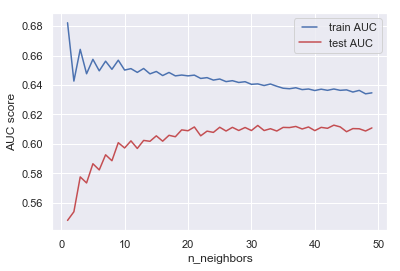

In [183]:
line1, = plt.plot(neighbors, train_results, 'b', label='train AUC')
line2, = plt.plot(neighbors, test_results, 'r', label='test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('n_neighbors')

increasing the n_neighbors improves the AUC score but still not good enough.
Almost no class separation capacity...
Check if the model is not overfitting at least by doing cross_val_score.

In [185]:
from sklearn.model_selection import cross_val_score
print(cross_val_score(model, x2_train, y2_train, cv=20))

[0.5915351  0.62109506 0.599261   0.60900235 0.62378233 0.60564327
 0.63184414 0.59509409 0.62331989 0.60248656 0.61290323 0.63004032
 0.62768817 0.5984543  0.62231183 0.60819892 0.60853495 0.61613445
 0.61983193 0.60773109]


cross_val_score: pretty consistent.  no overfitting

In [186]:
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

In [187]:
tuning_1={'n_neighbors':[10,20,30, 40, 50]}

In [188]:
tuning1=GridSearchCV(estimator=KNeighborsClassifier(), 
                     param_grid=tuning_1, scoring='accuracy',n_jobs=4, iid=False, cv=5)

In [189]:
tuning1.fit(x2_train, y2_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'n_neighbors': [10, 20, 30, 40, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [190]:
GridSearchCV.score(tuning1, x2_train, y2_train), tuning1.best_params_, tuning1.best_score_

(0.6338451716954506, {'n_neighbors': 50}, 0.6114173734802548)

In [191]:
new_KNN=KNeighborsClassifier(n_neighbors=50)

In [192]:
new_KNN.fit(x2_train, y2_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=50, p=2,
           weights='uniform')

In [193]:
print('Accuracy of the new_KNN on test set: {:,.3f}'.format(new_KNN.score(x2_test, y2_test)))

Accuracy of the new_KNN on test set: 0.612


In [194]:
y_predicted=new_KNN.predict(x2_test)

In [195]:
print(classification_report(y2_test, y_predicted))

              precision    recall  f1-score   support

         0.0       0.61      0.62      0.62      7497
         1.0       0.61      0.60      0.61      7385

   micro avg       0.61      0.61      0.61     14882
   macro avg       0.61      0.61      0.61     14882
weighted avg       0.61      0.61      0.61     14882



Model two: Random Forest Classifier

In [196]:
#RFC using default parameters

In [197]:
from sklearn import ensemble
rfc=ensemble.RandomForestClassifier()

In [198]:
rfc.fit(x2_train, y2_train)

/Users/laurakim/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [199]:
print('Accuracy of the rfc on test set: {:.3f}'.format(rfc.score(x2_test, y2_test)))
predicted=rfc.predict(x2_test)
print(classification_report(y2_test, predicted))

Accuracy of the rfc on test set: 0.601
              precision    recall  f1-score   support

         0.0       0.60      0.61      0.61      7497
         1.0       0.60      0.59      0.60      7385

   micro avg       0.60      0.60      0.60     14882
   macro avg       0.60      0.60      0.60     14882
weighted avg       0.60      0.60      0.60     14882



In [200]:
print(cross_val_score(rfc, x2_train, y2_train, cv=20))

[0.58246557 0.59858918 0.58784011 0.59993282 0.61168962 0.59993282
 0.62311051 0.58602151 0.6078629  0.5890457  0.59206989 0.59778226
 0.60987903 0.58669355 0.60483871 0.59543011 0.60013441 0.60336134
 0.59932773 0.61008403]


In [201]:
print(cross_val_score(rfc, x2_test, y2_test, cv=20))

[0.59865772 0.59731544 0.55302013 0.59463087 0.59865772 0.59274194
 0.5577957  0.56586022 0.58198925 0.56048387 0.56317204 0.57392473
 0.53360215 0.58467742 0.58870968 0.56182796 0.56451613 0.59757739
 0.55720054 0.59219381]


In [202]:
tuning_1={'n_estimators':[10,20,30],'max_depth':[2,3,4,5,6,7]}

In [203]:
tuning_2={'min_samples_split':[2,4,6,8,10,20,40,60,100]}

In [204]:
tuning_3={'min_samples_leaf':[1,3,5,7,9]}

In [205]:
tuning_4={'max_features':[1,2]}

In [208]:
tuning1=GridSearchCV(estimator=ensemble.RandomForestClassifier(criterion='gini', 
                    min_samples_split=2, min_samples_leaf=1, max_features=2, random_state=10), 
                   param_grid=tuning_1, scoring='accuracy',n_jobs=4, iid=False, cv=5)

In [209]:
tuning1.fit(x2_train, y2_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=2, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=10, verbose=0, warm_start=False),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'n_estimators': [10, 20, 30], 'max_depth': [2, 3, 4, 5, 6, 7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [210]:
GridSearchCV.score(tuning1, x2_train, y2_train), tuning1.best_params_, tuning1.best_score_

(0.5996404811504603, {'max_depth': 7, 'n_estimators': 30}, 0.588939146296527)

In [213]:
tuning2=GridSearchCV(estimator=ensemble.RandomForestClassifier(n_estimators=30, max_depth=7,criterion='gini', 
                    min_samples_leaf=1, max_features=2, random_state=10), 
                   param_grid=tuning_2, scoring='accuracy',n_jobs=4, iid=False, cv=5)

In [214]:
tuning2.fit(x2_train, y2_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=7, max_features=2, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=None,
            oob_score=False, random_state=10, verbose=0, warm_start=False),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'min_samples_split': [2, 4, 6, 8, 10, 20, 40, 60, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [215]:
GridSearchCV.score(tuning2, x2_train, y2_train), tuning2.best_params_, tuning2.best_score_

(0.5994052819030979, {'min_samples_split': 20}, 0.5890735548986776)

In [216]:
tuning3=GridSearchCV(estimator=ensemble.RandomForestClassifier(n_estimators=30, max_depth=7,criterion='gini', 
                    min_samples_split=20, max_features=2, random_state=10), 
                   param_grid=tuning_3, scoring='accuracy',n_jobs=4, iid=False, cv=5)

In [217]:
tuning3.fit(x2_train, y2_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=7, max_features=2, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=20,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=None,
            oob_score=False, random_state=10, verbose=0, warm_start=False),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'min_samples_leaf': [1, 3, 5, 7, 9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [218]:
GridSearchCV.score(tuning3, x2_train, y2_train), tuning3.best_params_, tuning3.best_score_

(0.5989852832470937, {'min_samples_leaf': 9}, 0.5892919886331821)

In [219]:
tuning4=GridSearchCV(estimator=ensemble.RandomForestClassifier(n_estimators=30, max_depth=7,criterion='gini', 
                    min_samples_split=20, min_samples_leaf=9, random_state=10), 
                   param_grid=tuning_4, scoring='accuracy',n_jobs=4, iid=False, cv=5)

In [220]:
tuning4.fit(x2_train, y2_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=7, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=9, min_samples_split=20,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=None,
            oob_score=False, random_state=10, verbose=0, warm_start=False),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'max_features': [1, 2]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='accuracy',
       verbose=0)

In [221]:
GridSearchCV.score(tuning4, x2_train, y2_train), tuning4.best_params_, tuning4.best_score_

(0.5931893017942342, {'max_features': 1}, 0.5920473847332781)

In [222]:
new_rfc=ensemble.RandomForestClassifier(n_estimators=30, criterion='gini', max_depth=7, min_samples_split=20, min_samples_leaf=9,
                                       max_features=1, random_state=10)

In [223]:
new_rfc.fit(x2_train, y2_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=7, max_features=1, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=9, min_samples_split=20,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=None,
            oob_score=False, random_state=10, verbose=0, warm_start=False)

In [224]:
print('Accuracy of the new_rfc on test set: {:,.3f}'.format(new_rfc.score(x2_test, y2_test)))

Accuracy of the new_rfc on test set: 0.580


In [225]:
y_predicted=new_rfc.predict(x2_test)

In [226]:
print(classification_report(y2_test, y_predicted))

              precision    recall  f1-score   support

         0.0       0.60      0.50      0.54      7497
         1.0       0.57      0.67      0.61      7385

   micro avg       0.58      0.58      0.58     14882
   macro avg       0.58      0.58      0.58     14882
weighted avg       0.58      0.58      0.58     14882



In [227]:
print(cross_val_score(new_rfc, x2_test, y2_test, cv=20))

[0.59463087 0.61744966 0.5409396  0.60268456 0.62550336 0.58736559
 0.58467742 0.55645161 0.58602151 0.57795699 0.57526882 0.59005376
 0.59543011 0.59005376 0.61827957 0.58467742 0.58736559 0.6218035
 0.57738896 0.58950202]


Model three: GBM

In [231]:
from sklearn.ensemble import GradientBoostingClassifier

In [232]:
gbm=GradientBoostingClassifier()

In [233]:
gbm.fit(x2_train, y2_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [238]:
features=list(x2)

Text(0, 0.5, 'Feature Importance Score')

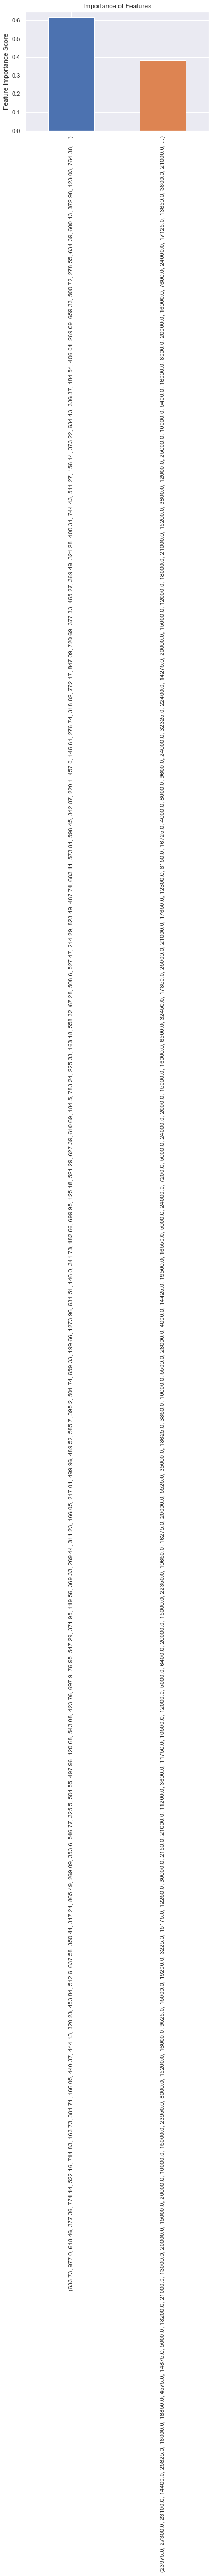

In [245]:
feature_importance=pd.Series(gbm.feature_importances_, features).sort_values(ascending=False)
feature_importance.plot(kind='bar', title='Importance of Features')
plt.ylabel('Feature Importance Score')

feature 'installment' > 'loan amount'

In [246]:
print('Accuracy of the GBM on test set: {:.3f}'.format(gbm.score(x2_test, y2_test)))
y_pred= gbm.predict(x2_test)
print(classification_report(y2_test, y_pred))

Accuracy of the GBM on test set: 0.587
              precision    recall  f1-score   support

         0.0       0.59      0.62      0.60      7497
         1.0       0.59      0.56      0.57      7385

   micro avg       0.59      0.59      0.59     14882
   macro avg       0.59      0.59      0.59     14882
weighted avg       0.59      0.59      0.59     14882



In [277]:
gbm_tuning1={'n_estimators':[100,250,500,750,1000], 'learning_rate':[0.15,0.1,0.05,0.01,0.005,0.001]}

In [278]:
gbm_tuning=GridSearchCV(estimator=GradientBoostingClassifier(max_depth=4, min_samples_split=2, min_samples_leaf=1,
                                                            subsample=1, max_features='sqrt', random_state=10),
                       param_grid=gbm_tuning1, scoring='accuracy',n_jobs=4, iid=False, cv=5)

In [279]:
gbm_tuning.fit(x2_train, y2_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=4,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sam...        subsample=1, tol=0.0001, validation_fraction=0.1, verbose=0,
              warm_start=False),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'n_estimators': [100, 250, 500, 750, 1000], 'learning_rate': [0.15, 0.1, 0.05, 0.01, 0.005, 0.001]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [281]:
GridSearchCV.score(gbm_tuning, x2_train, y2_train), gbm_tuning.best_params_, gbm_tuning.best_score_

(0.6563906995497615,
 {'learning_rate': 0.05, 'n_estimators': 1000},
 0.6227406095733785)

In [283]:
new_gbm=GradientBoostingClassifier(criterion='friedman_mse', n_estimators=1000,
              learning_rate=0.05, loss='deviance', max_depth=4,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, subsample=1, tol=0.0001, validation_fraction=0.1, verbose=0,
              warm_start=False)

In [285]:
new_gbm.fit(x2_train, y2_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=4,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=1000,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1, tol=0.0001, validation_fraction=0.1, verbose=0,
              warm_start=False)

In [287]:
gbm_tuning_y_predicted=new_gbm.predict(x2_test)

In [288]:
print(classification_report(y2_test, gbm_tuning_y_predicted))

              precision    recall  f1-score   support

         0.0       0.63      0.62      0.62      7497
         1.0       0.62      0.63      0.62      7385

   micro avg       0.62      0.62      0.62     14882
   macro avg       0.62      0.62      0.62     14882
weighted avg       0.62      0.62      0.62     14882



In [289]:
print('Accuracy of the new gbm model after tuning on test set: {:,.3f}'.format(gbm_tuning.score(x2_test, y2_test)))

Accuracy of the new gbm model after tuning on test set: 0.622


In [290]:
gbm_tuning2={'max_depth':[2,3,4,5,6,7]}

In [291]:
gbm_second_tuning=GridSearchCV(estimator=GradientBoostingClassifier(criterion='friedman_mse', n_estimators=1000,
              learning_rate=0.05, loss='deviance',
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, subsample=1, tol=0.0001, validation_fraction=0.1, verbose=0,
              warm_start=False),
                       param_grid=gbm_tuning2, scoring='accuracy',n_jobs=4, iid=False, cv=5)

In [292]:
gbm_second_tuning.fit(x2_train, y2_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=3,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sa...        subsample=1, tol=0.0001, validation_fraction=0.1, verbose=0,
              warm_start=False),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'max_depth': [2, 3, 4, 5, 6, 7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [293]:
GridSearchCV.score(gbm_second_tuning, x2_train, y2_train), gbm_second_tuning.best_params_, gbm_second_tuning.best_score_

(0.6545763053558229, {'max_depth': 4}, 0.6233117304187461)

In [301]:
new_gbm2=GradientBoostingClassifier(criterion='friedman_mse', n_estimators=1000,
              learning_rate=0.05, loss='deviance', max_depth=4,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, subsample=1, tol=0.0001, validation_fraction=0.1, verbose=0,
              warm_start=False)

In [302]:
new_gbm2.fit(x2_train, y2_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=4,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=1000,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1, tol=0.0001, validation_fraction=0.1, verbose=0,
              warm_start=False)

In [303]:
gbm_tuning_y_predicted2=new_gbm2.predict(x2_test)

In [304]:
print(classification_report(y2_test, gbm_tuning_y_predicted2))

              precision    recall  f1-score   support

         0.0       0.62      0.62      0.62      7497
         1.0       0.62      0.62      0.62      7385

   micro avg       0.62      0.62      0.62     14882
   macro avg       0.62      0.62      0.62     14882
weighted avg       0.62      0.62      0.62     14882



In [269]:
#using features that have moderate correlation with loan status:

In [294]:
x3=final_data_table[['interest rate in %', 'total_acc']].values
y3=x.loc[:,219].values

In [295]:
x3_train, x3_test, y3_train, y3_test = train_test_split(x3,y3, test_size=0.2, random_state=1)

In [296]:
#KNN:
model = KNeighborsClassifier()

In [297]:
model.fit(x3_train, y3_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [298]:
print(cross_val_score(model, x3_train, y3_train, cv=20))

[0.5797783  0.58817602 0.5602956  0.60127645 0.58179375 0.59287874
 0.59858918 0.59173387 0.58198925 0.58098118 0.56485215 0.59005376
 0.59912634 0.58702957 0.59173387 0.57526882 0.57358871 0.59865546
 0.58554622 0.57747899]


In [299]:
y_predicted=model.predict(x3_test)

In [300]:
print(classification_report(y3_test, y_predicted))

              precision    recall  f1-score   support

         0.0       0.59      0.58      0.59      7497
         1.0       0.58      0.59      0.59      7385

   micro avg       0.59      0.59      0.59     14882
   macro avg       0.59      0.59      0.59     14882
weighted avg       0.59      0.59      0.59     14882



In [305]:
tuning_1={'n_neighbors':[10,20,30, 40, 50]}

In [306]:
knn_tuning1=GridSearchCV(estimator=KNeighborsClassifier(), 
                     param_grid=tuning_1, scoring='accuracy',n_jobs=4, iid=False, cv=5)

In [307]:
knn_tuning1.fit(x3_train, y3_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'n_neighbors': [10, 20, 30, 40, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [308]:
GridSearchCV.score(knn_tuning1, x3_train, y3_train), knn_tuning1.best_params_, knn_tuning1.best_score_

(0.64355554062227, {'n_neighbors': 50}, 0.6255462310951919)

In [309]:
new_knn=KNeighborsClassifier(n_neighbors=50)

In [310]:
new_knn.fit(x3_train, y3_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=50, p=2,
           weights='uniform')

In [311]:
print('Accuracy of the new_knn on test set: {:,.3f}'.format(new_knn.score(x3_test, y3_test)))

Accuracy of the new_knn on test set: 0.624


In [312]:
new_knn_y_predicted=model.predict(x3_test)

In [313]:
print(classification_report(y3_test, new_knn_y_predicted))

              precision    recall  f1-score   support

         0.0       0.59      0.58      0.59      7497
         1.0       0.58      0.59      0.59      7385

   micro avg       0.59      0.59      0.59     14882
   macro avg       0.59      0.59      0.59     14882
weighted avg       0.59      0.59      0.59     14882



In [314]:
gbm.fit(x3_train, y3_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [315]:
print('Accuracy of the gbm on test set: {:,.3f}'.format(gbm.score(x3_test, y3_test)))

Accuracy of the gbm on test set: 0.635


In [316]:
gbm_tuning1={'n_estimators':[100,250,500,750,1000], 'learning_rate':[0.15,0.1,0.05,0.01,0.005,0.001]}

In [317]:
gbm_tuning=GridSearchCV(estimator=GradientBoostingClassifier(max_depth=4, min_samples_split=2, min_samples_leaf=1,
                                                            subsample=1, max_features='sqrt', random_state=10),
                       param_grid=gbm_tuning1, scoring='accuracy',n_jobs=4, iid=False, cv=5)

In [318]:
gbm_tuning.fit(x3_train, y3_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=4,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sam...        subsample=1, tol=0.0001, validation_fraction=0.1, verbose=0,
              warm_start=False),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'n_estimators': [100, 250, 500, 750, 1000], 'learning_rate': [0.15, 0.1, 0.05, 0.01, 0.005, 0.001]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [319]:
GridSearchCV.score(gbm_tuning, x3_train, y3_train), gbm_tuning.best_params_, gbm_tuning.best_score_

(0.6374403601908474,
 {'learning_rate': 0.01, 'n_estimators': 100},
 0.6366341956888097)

In [320]:
new_gbm=GradientBoostingClassifier(criterion='friedman_mse', n_estimators=100,
              learning_rate=0.01, loss='deviance', max_depth=4,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, subsample=1, tol=0.0001, validation_fraction=0.1, verbose=0,
              warm_start=False)

In [321]:
new_gbm.fit(x3_train, y3_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=4,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1, tol=0.0001, validation_fraction=0.1, verbose=0,
              warm_start=False)

In [322]:
gbm_tuning_y_predicted=new_gbm.predict(x3_test)

In [323]:
print(classification_report(y3_test, gbm_tuning_y_predicted))

              precision    recall  f1-score   support

         0.0       0.65      0.60      0.62      7497
         1.0       0.62      0.67      0.65      7385

   micro avg       0.63      0.63      0.63     14882
   macro avg       0.64      0.64      0.63     14882
weighted avg       0.64      0.63      0.63     14882



Investor's net gain calculation:
(average interest rate) - (Expected losses (borrowers not able to payback the loans, default)) - (LendingClub fees) = net return per year.


Expected losses = unable to pay then goes into default, pay off early (adjusting your average interest rate). 

When the borrower is not able to payback the loan for more than 30 days, that's when the lenders become concerned that it could end up going into default.  

Goal was to build a model that will identify borrowers as high risk vs. low risk to invest in, which could affect the expected losses: low risk (loan_status: paid off).  high risk (loan_status: late, default, charged off).    


However, with the borrowers' background information available on the LendingClub's website, separating borrowers into high and low risk groups was not successful with all the models used had accuracy of only about 60%.  

So Expected losses is hard to predict. 
Investors can't change LendingClub fees.

Increase average interest rate (higher loan amount, longer loan term in months).  However, investors also 
know that these three features is also moderately correlated with total recovery of principal, meaning higher they are, also higher chance the borrower may go into default, charged off.


In conclusion, from an investor's side, trying to increasing profit comes with increased risk.  
Predicting that risk (goal of this project) was not successful with given information about borrowers on the LendingClub's website.

My only recommendation is to search for different features that might affect expected losses.